# 03. Logistic Regression

**Author:** [Your Name/GitHub Username]
**Date:** June 2, 2025

## Introduction

Logistic Regression is a supervised learning algorithm used primarily for **binary classification** problems, where the goal is to predict one of two possible outcomes (e.g., Yes/No, Spam/Not Spam, Malignant/Benign). Despite its name, it's a classification algorithm, not a regression one.

It models the probability that a given input point belongs to a particular class. This probability is then mapped to a discrete class prediction.

* **Type:** Supervised Learning
* **Task:** Binary Classification (can be extended to multiclass, e.g., One-vs-Rest)
* **Goal:** To find a relationship between features and the probability of a particular outcome using a sigmoid (logistic) function.

## Theoretical Background

### Key Concepts

1.  **The Logistic (Sigmoid) Function:**
    Logistic Regression uses the sigmoid function to transform a linear combination of input features into a probability score (between 0 and 1).
    The linear combination is $z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n = \theta^T X$.
    The sigmoid function is defined as:
    $\sigma(z) = \frac{1}{1 + e^{-z}}$
    * If $z \rightarrow \infty$, $\sigma(z) \rightarrow 1$.
    * If $z \rightarrow -\infty$, $\sigma(z) \rightarrow 0$.
    * If $z = 0$, $\sigma(z) = 0.5$.
    The output $h_{\theta}(x) = \sigma(\theta^T X)$ represents the estimated probability that $y=1$ given $X$ and parameters $\theta$, i.e., $P(y=1 | X; \theta)$.

2.  **Decision Boundary:**
    To make a discrete class prediction, we set a threshold (commonly 0.5) on the probability:
    * If $P(y=1 | X; \theta) \ge 0.5$, predict class 1.
    * If $P(y=1 | X; \theta) < 0.5$, predict class 0.
    This corresponds to whether $z = \theta^T X \ge 0$ or $z < 0$. The equation $\theta^T X = 0$ defines the decision boundary, which is linear for logistic regression.

3.  **Cost Function (Log Loss / Binary Cross-Entropy):**
    Unlike Linear Regression which uses Mean Squared Error (MSE), Logistic Regression uses a cost function called Log Loss (or Binary Cross-Entropy). MSE is not suitable because the sigmoid function would make the cost function non-convex, leading to multiple local minima.
    The cost function for a single training example is:
    Cost$(h_{\theta}(x), y) = -[y \log(h_{\theta}(x)) + (1-y) \log(1-h_{\theta}(x))]$
    The overall cost function for $m$ training examples is:
    $J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_{\theta}(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))]$
    The goal is to find parameters $\theta$ that minimize $J(\theta)$.

4.  **Optimization (Gradient Descent):**
    Gradient Descent is typically used to find the optimal $\theta$ values by iteratively updating them in the direction that reduces the cost function. Scikit-learn's `LogisticRegression` handles this optimization internally using various solvers (e.g., 'liblinear', 'lbfgs', 'saga').

### Assumptions
* **Independence of errors:** Residuals are independent (similar to linear regression).
* **Little to no multicollinearity:** Independent variables should not be too highly correlated.
* **Linearity of independent variables and log-odds:** The independent variables are linearly related to the log-odds of the outcome: $\log(\frac{P(y=1)}{1-P(y=1)}) = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n$.
* **Large sample size:** Logistic regression generally requires a larger sample size for stable results compared to linear regression.

### Pros
* Simple to implement, interpret, and efficient to train.
* Outputs well-calibrated probabilities in addition to class predictions.
* Coefficients can be interpreted as indicators of feature importance (in terms of log-odds).
* Performs well when the dataset is linearly separable.
* Less prone to overfitting with L1/L2 regularization (which is often built-in).

### Cons
* Assumes a linear relationship between features and the log-odds of the outcome. May not perform well with complex, non-linear relationships.
* Can be sensitive to outliers.
* Performance can suffer if there's high multicollinearity among features.
* May not perform as well as more complex models like SVMs or tree-based ensembles for highly complex datasets.

### Common Use Cases
* Spam detection (spam vs. not spam).
* Medical diagnosis (e.g., predicting presence or absence of a disease like cancer based on symptoms/tests).
* Credit scoring (predicting default vs. non-default).
* Customer churn prediction (churn vs. not churn).
* Image classification (e.g., cat vs. dog, though deep learning often preferred for complex images).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics # For accuracy, confusion matrix, classification report, ROC AUC

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python

For this demonstration, we'll use the **Breast Cancer Wisconsin (Diagnostic) dataset** from Scikit-learn. This is a classic binary classification dataset where the goal is to predict whether a tumor is malignant or benign based on several features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.

In [2]:
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()

# Create a Pandas DataFrame for features and a Series for the target
X_df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y_s = pd.Series(cancer_data.target, name='Target') # 0 for malignant, 1 for benign

# Display basic information
print("Features (X) - First 5 rows:")
print(X_df.head())
print(f"\nShape of features: {X_df.shape}")

print("\nTarget (y) - Class distribution:")
print(y_s.value_counts())
print(f"Target names: {cancer_data.target_names}") # 0: malignant, 1: benign

print("\nDataset Description (Brief):")
print(cancer_data.DESCR.split('\n')[0]) # Print just the first line of DESCR

Features (X) - First 5 rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  wo


Missing values in features:
False

Basic statistics of features (first few columns):
       mean radius  mean texture  mean perimeter    mean area  mean smoothness
count   569.000000    569.000000      569.000000   569.000000       569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360
std       3.524049      4.301036       24.298981   351.914129         0.014064
min       6.981000      9.710000       43.790000   143.500000         0.052630
25%      11.700000     16.170000       75.170000   420.300000         0.086370
50%      13.370000     18.840000       86.240000   551.100000         0.095870
75%      15.780000     21.800000      104.100000   782.700000         0.105300
max      28.110000     39.280000      188.500000  2501.000000         0.163400


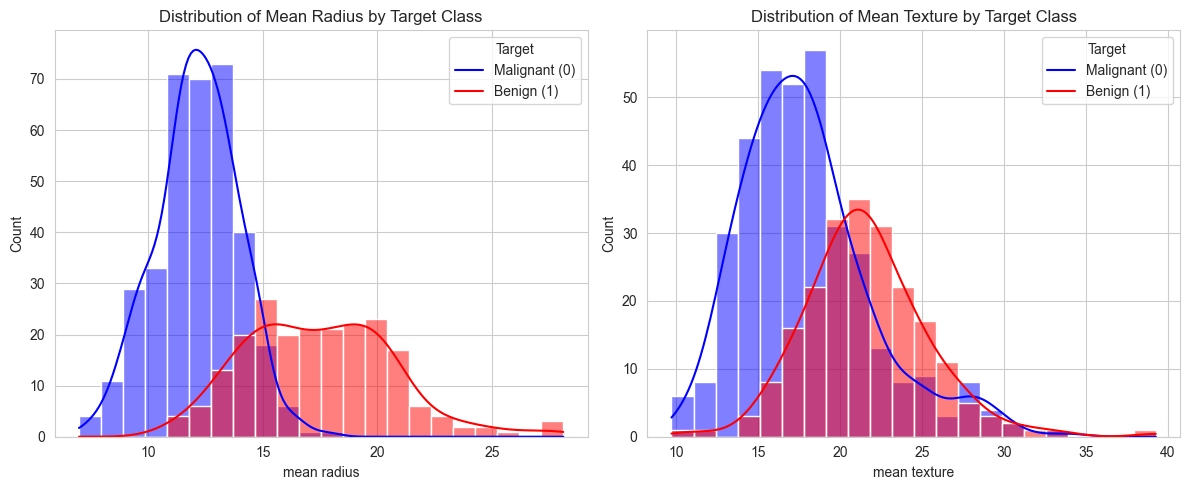

In [3]:
# Brief EDA: Check for missing values and basic statistics
print("\nMissing values in features:")
print(X_df.isnull().sum().any()) # Should be False for this dataset

print("\nBasic statistics of features (first few columns):")
print(X_df.iloc[:, :5].describe())

# Visualize the distribution of a couple of features for each class
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=X_df, x='mean radius', hue=y_s, kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Mean Radius by Target Class')
plt.legend(title='Target', labels=['Malignant (0)', 'Benign (1)'])


plt.subplot(1, 2, 2)
sns.histplot(data=X_df, x='mean texture', hue=y_s, kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Mean Texture by Target Class')
plt.legend(title='Target', labels=['Malignant (0)', 'Benign (1)'])

plt.tight_layout()
plt.show()

The plots show that features like 'mean radius' and 'mean texture' have different distributions for malignant (0) and benign (1) tumors, suggesting they could be useful for classification.

In [4]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.3, random_state=42, stratify=y_s)
# stratify=y_s ensures that the class proportions are similar in train and test sets

print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set size: X_test: {X_test.shape}, y_test: {y_test.shape}")

# 2. Feature Scaling
# Logistic Regression benefits from feature scaling, especially when using solvers
# that are sensitive to feature magnitudes (like 'lbfgs', 'saga').
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Only transform on test set

# Convert scaled arrays back to DataFrames (optional, for inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_df.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_df.columns)

print("\nFirst 5 rows of scaled training data:")
print(X_train_scaled_df.head())

Training set size: X_train: (398, 30), y_train: (398,)
Testing set size: X_test: (171, 30), y_test: (171,)

First 5 rows of scaled training data:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.709821     -0.258417       -0.637396  -0.711996         1.628430   
1    -0.830331      2.231127       -0.874980  -0.779081        -1.597569   
2    -1.011097     -0.227270       -1.035172  -0.911780        -1.077779   
3    -0.382721     -0.111581       -0.408966  -0.453660         0.072810   
4    -0.804508     -1.401961       -0.810071  -0.773196         0.191319   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          0.847289        0.166501             0.196420       0.542716   
1         -1.267717       -1.086471            -1.243232      -2.658543   
2         -1.098096       -0.841650            -0.955767       2.023790   
3         -0.443255       -0.756276            -0.782409      -0.163916   
4         -0.507801   

In [5]:
# Create a Logistic Regression model instance
# Common solvers: 'liblinear' (good for small datasets), 'lbfgs' (default), 'saga' (good for large datasets, supports L1)
# C is the inverse of regularization strength; smaller C means stronger regularization.
log_reg_model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)

# Fit the model to the scaled training data
log_reg_model.fit(X_train_scaled, y_train)

print("Logistic Regression model training completed.")

Logistic Regression model training completed.


In [6]:
# Make predictions on the scaled test set
y_pred_class = log_reg_model.predict(X_test_scaled)         # Predicts class labels (0 or 1)
y_pred_proba = log_reg_model.predict_proba(X_test_scaled) # Predicts class probabilities [P(class=0), P(class=1)]

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class,
    'Prob_Class_0 (Malignant)': y_pred_proba[:, 0],
    'Prob_Class_1 (Benign)': y_pred_proba[:, 1]
})
print("\nActual vs Predicted values and Probabilities (first 5):")
print(predictions_df.head())


Actual vs Predicted values and Probabilities (first 5):
   Actual Target  Predicted Class  Prob_Class_0 (Malignant)  \
0              0                0                  0.968408   
1              1                1                  0.051167   
2              1                1                  0.017385   
3              0                0                  0.999011   
4              0                0                  0.720666   

   Prob_Class_1 (Benign)  
0               0.031592  
1               0.948833  
2               0.982615  
3               0.000989  
4               0.279334  


### Model Evaluation Metrics
We will evaluate the model using:
* Accuracy
* Confusion Matrix
* Classification Report (Precision, Recall, F1-score)
* ROC Curve and AUC (Area Under the Curve)


Accuracy: 0.9883


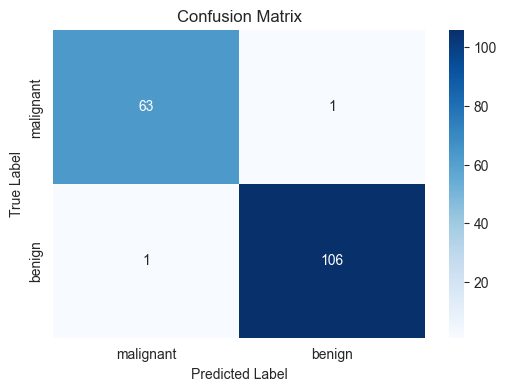

True Negatives (Malignant correctly predicted): 63
False Positives (Malignant predicted as Benign - Type I Error): 1
False Negatives (Benign predicted as Malignant - Type II Error): 1
True Positives (Benign correctly predicted): 106

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



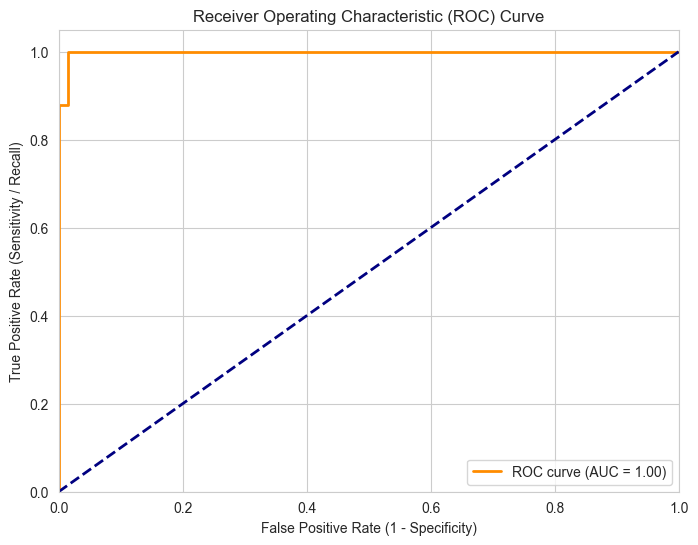


AUC Score: 0.9981


In [7]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cancer_data.target_names, yticklabels=cancer_data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Malignant correctly predicted): {tn}")
print(f"False Positives (Malignant predicted as Benign - Type I Error): {fp}") # Actually Malignant, predicted Benign if 0=M, 1=B
print(f"False Negatives (Benign predicted as Malignant - Type II Error): {fn}") # Actually Benign, predicted Malignant if 0=M, 1=B
print(f"True Positives (Benign correctly predicted): {tp}")
# Correcting interpretation based on sklearn's confusion_matrix (y_true labels on rows, y_pred on columns)
# And target names: 0 = malignant, 1 = benign
# TN: True Malignant (Predicted Malignant, Actual Malignant)
# FP: False Benign (Predicted Benign, Actual Malignant)
# FN: False Malignant (Predicted Malignant, Actual Benign)
# TP: True Benign (Predicted Benign, Actual Benign)


# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=cancer_data.target_names)
print("\nClassification Report:")
print(class_report)

# 4. ROC Curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1]) # Use probabilities of the positive class (Benign=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")

### Interpreting the Metrics:
* **Accuracy:** Overall, how often the classifier is correct.
* **Confusion Matrix:**
    * **True Positives (TP - for Benign):** Correctly identified benign tumors.
    * **True Negatives (TN - for Malignant):** Correctly identified malignant tumors.
    * **False Positives (FP - Type I Error):** Malignant tumors incorrectly identified as benign. (This is class 1, benign, being falsely predicted).
    * **False Negatives (FN - Type II Error):** Benign tumors incorrectly identified as malignant. (This is class 1, benign, being missed).
    * *Note: The interpretation of FP/FN depends on which class is considered "positive". Here, class 1 (Benign) is often treated as positive by `roc_curve`.*
* **Precision:** For a given class, what proportion of positive identifications was actually correct? (TP / (TP + FP)). High precision for 'benign' means when the model predicts 'benign', it's usually correct.
* **Recall (Sensitivity):** For a given class, what proportion of actual positives was identified correctly? (TP / (TP + FN)). High recall for 'malignant' means the model finds most of the actual malignant tumors.
* **F1-score:** The harmonic mean of precision and recall. Useful when you need a balance between Precision and Recall.
* **AUC (Area Under the ROC Curve):** Measures the entire two-dimensional area underneath the entire ROC curve. An AUC of 1 represents a perfect model, while an AUC of 0.5 represents a model no better than random guessing. Our model's AUC of [insert AUC value] is quite good.

## Interpreting Coefficients (Log-Odds)

The coefficients ($\theta_i$) in Logistic Regression indicate the change in the **log-odds** of the outcome for a one-unit increase in the corresponding predictor variable, holding all other variables constant.

$\log(\frac{P(y=1)}{1-P(y=1)}) = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n$

* If a coefficient $\theta_i$ is positive, an increase in feature $x_i$ increases the log-odds (and thus the probability) of $y=1$.
* If $\theta_i$ is negative, an increase in $x_i$ decreases the log-odds (and probability) of $y=1$.
* If $\theta_i$ is zero, feature $x_i$ has no effect on the log-odds of $y=1$.

The exponentiated coefficient, $e^{\theta_i}$, is the **odds ratio (OR)**.
* OR > 1: Increases odds.
* OR < 1: Decreases odds.
* OR = 1: No change in odds.


Model Coefficients (Log-Odds and Odds Ratio):
                    Feature  Coefficient (Log-Odds)  Odds Ratio
5          mean compactness                0.657340    1.929653
15        compactness error                0.575199    1.777484
11            texture error                0.361166    1.435001
19  fractal dimension error                0.342947    1.409094
18           symmetry error                0.319289    1.376149
16          concavity error                0.168790    1.183872
9    mean fractal dimension                0.029771    1.030219
25        worst compactness                0.028321    1.028726
8             mean symmetry               -0.115820    0.890636
4           mean smoothness               -0.159721    0.852382
29  worst fractal dimension               -0.160631    0.851607
14         smoothness error               -0.186637    0.829745
12          perimeter error               -0.211129    0.809670
17     concave points error               -0.257350    0.

/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_41309/2986809359.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient (Log-Odds)', y='Feature', data=top_coef_df, palette='coolwarm')


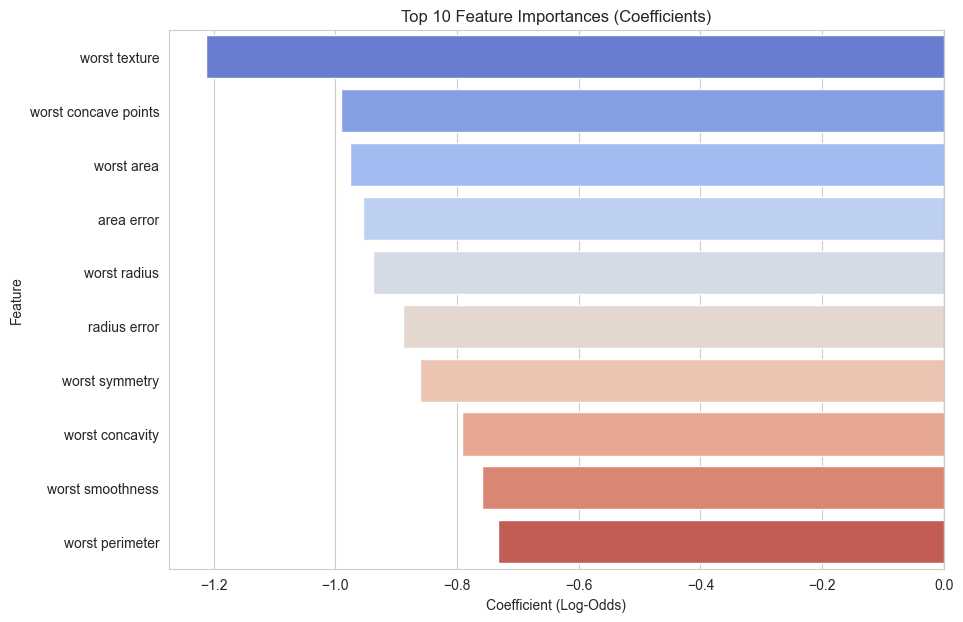

In [10]:
# Get the coefficients and feature names
coefficients = log_reg_model.coef_[0] # log_reg_model.coef_ is a 2D array for binary case
feature_names = X_df.columns

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient (Log-Odds)': coefficients})
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient (Log-Odds)'])
coef_df = coef_df.sort_values(by='Coefficient (Log-Odds)', ascending=False)

print("\nModel Coefficients (Log-Odds and Odds Ratio):")
print(coef_df)

# Plotting top N features by absolute coefficient value
n_top_features = 10
top_coef_df = coef_df.reindex(coef_df['Coefficient (Log-Odds)'].abs().sort_values(ascending=False).index).head(n_top_features)

plt.figure(figsize=(10, 7))
sns.barplot(x='Coefficient (Log-Odds)', y='Feature', data=top_coef_df, palette='coolwarm')
plt.title(f'Top {n_top_features} Feature Importances (Coefficients)')
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

The bar plot shows the features with the largest (absolute) coefficients. Features with positive coefficients increase the log-odds of the tumor being benign (class 1), while negative coefficients increase the log-odds of it being malignant (class 0).
*Remember these coefficients are for scaled data.*

## Conclusion & Key Takeaways

* Logistic Regression is a robust and interpretable algorithm for binary classification.
* It models the probability of an outcome using the sigmoid function applied to a linear combination of features.
* Feature scaling is generally recommended for optimal performance.
* Evaluation requires various metrics beyond accuracy, including precision, recall, F1-score, confusion matrix, and ROC AUC, especially for imbalanced datasets or when costs of misclassification differ.
* The coefficients can be interpreted in terms of log-odds and odds ratios, providing insights into feature influence.
* The model produced good results on the breast cancer dataset, effectively distinguishing between malignant and benign tumors.

## Further Reading/References (Optional)

* [Scikit-learn LogisticRegression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [StatQuest: Logistic Regression, Clearly Explained](https://www.youtube.com/watch?v=nk2CQITm_eo)
* Chapter on Logistic Regression in "An Introduction to Statistical Learning" by James, Witten, Hastie, and Tibshirani.